# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math

TensorFlow 1.x selected.


### Importar a base de dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/PROJETO_FINAL_BIMASTER/temperatura_BP-140106.csv')

#Conversão das temperaturas para número inteiro. Teste para ver se ajuda a RN. 
dataset = dataset.astype({"TEMPERATURA": int})

#calculando tamanho dos conjuntos de treino e teste
train_size = math.ceil(len(dataset)*0.78)
test_size  = len(dataset) - train_size 

#Separando conjuto de treino e teste apenas com valor da série
train_set = dataset.iloc[0:train_size, 1:2].values
test_set  = dataset.iloc[train_size:(train_size + test_size), 1:2].values

### gráfico da série temporal

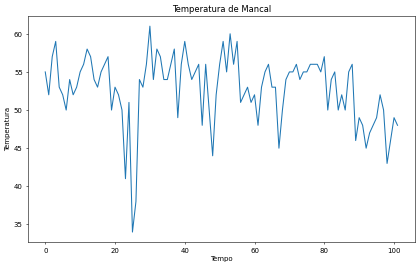

In [40]:
plt.figure(figsize=(10, 6), dpi=50)

plt.plot(np.vstack((train_set,test_set)))
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.show()

### Normalização

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

### Criar a estrutura de dados com janela WINDOW e output OUTPUTSIZE para entrada na RN

In [6]:
window     = 5
output_size = 3

X_train = []
y_train = []

#for i in range(window, train_size - output_size):
#    X_train.append(training_set_scaled[i-window:i, 0])
#    y_train.append(training_set_scaled[i:i + output_size, 0])
#X_train, y_train = np.array(X_train), np.array(y_train)

def prepareSetRN(windowSize, outputSize, flatSet ):
    preparedX = []
    preparedY = []
    setSize = len(flatSet)
    for i in range(windowSize, setSize - (outputSize-1)):
        preparedX.append(flatSet[i-window:i, 0])
        preparedY.append(flatSet[i:i + output_size, 0])

    preparedX, preparedY = np.array(preparedX), np.array(preparedY)

    return preparedX, preparedY 

X_train, y_train = prepareSetRN(window, output_size, training_set_scaled)

### Reshaping

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
X_train.shape

(73, 5, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


### Construção da Rede completa

In [10]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
#regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.3))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = False))
regressor.add(Dropout(0.3))
 
# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50, return_sequences = False))
#regressor.add(Dropout(0.3))

# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50, return_sequences = False))
#regressor.add(Dropout(0.25))

# camada de saída
regressor.add(Dense(units = output_size, activation='linear'))
#Testar sigmoid e linear

# Compilar a rede
regressor.compile(optimizer = 'Adadelta', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Visualizar a rede
regressor.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 150)            91200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 150)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                73920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 243       
Total params: 165,363
Trainable params: 165,363
Non-trainable params: 0
_________________________________________________________________


### Treinamento

In [11]:
 y_train.shape

(73, 3)

In [12]:
regressor.fit(X_train, y_train, epochs = 500, batch_size = 20)


Epoch 1/500
73/73 [==============================] - 1s 9ms/step - loss: 0.4404 - mean_absolute_error: 0.6412
Epoch 2/500
73/73 [==============================] - 0s 999us/step - loss: 0.2067 - mean_absolute_error: 0.4246
Epoch 3/500
73/73 [==============================] - 0s 851us/step - loss: 0.0586 - mean_absolute_error: 0.1986
Epoch 4/500
73/73 [==============================] - 0s 860us/step - loss: 0.0504 - mean_absolute_error: 0.1697
Epoch 5/500
73/73 [==============================] - 0s 823us/step - loss: 0.0441 - mean_absolute_error: 0.1613
Epoch 6/500
73/73 [==============================] - 0s 873us/step - loss: 0.0434 - mean_absolute_error: 0.1590
Epoch 7/500
73/73 [==============================] - 0s 934us/step - loss: 0.0444 - mean_absolute_error: 0.1609
Epoch 8/500
73/73 [==============================] - 0s 887us/step - loss: 0.0421 - mean_absolute_error: 0.1543
Epoch 9/500
73/73 [==============================] - 0s 896us/step - loss: 0.0406 - mean_absolute_error: 

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

### Construir a estrutura para teste

In [13]:
test_set_scaled = sc.transform(test_set)

X_test = []
y_test = []

X_test, y_test = prepareSetRN(window, output_size, test_set_scaled)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [31]:
def backToFlat( windowSet ):
    flatSet     = []
    window_size = windowSet.shape[1]
    setSize     = len(windowSet)

    for i in range(0, setSize):
        flatSet.append(windowSet[i, 0])
        
    flatSet.append(windowSet[setSize-1, 1])
    flatSet.append(windowSet[setSize-1, 2])

    flatSet = np.array(flatSet)

    return np.reshape(flatSet, (flatSet.shape[0], 1)) 

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

test_predicted = backToFlat(predicted)

predicted = regressor.predict(X_train)
predicted = sc.inverse_transform(predicted)

training_predicted = backToFlat(predicted)

### Visualizar os resultados de treino e teste

In [33]:
len(train_set) + len(test_set)

102

In [36]:
len(train_set[0:window]), len(training_predicted), len(test_predicted)

(5, 75, 17)

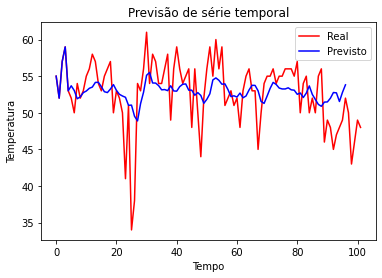

In [32]:
allTargetData = np.vstack((train_set, test_set))
allForecastedData = np.vstack((train_set[0:window], training_predicted, test_set[0:window], test_predicted))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [ ]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

In [ ]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

In [ ]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')